Connected to .venv (Python 3.12.9)

## Comparison of a vanilla ANN to sparse dendritically inspired ANN on Fashion-MNSIT

### Main code and implementation

In [ ]:
try:
    import cupy as cp

    # Test if CuPy can actually access CUDA and random number generator
    cp.cuda.Device(0).compute_capability
    cp.random.seed(1)  # Test if random number generator works
    print("Using CuPy (GPU acceleration)")
except (ImportError, Exception) as e:
    import numpy as cp

    print(f"CuPy not available or CUDA error ({type(e).__name__}), using NumPy (CPU)")
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm


class CrossEntropy:
    def __init__(self):
        self.softmax_output = None
        self.target = None
        self.batch_size = None

    def forward(self, logits, target):
        # Handle both single samples and batches
        if logits.ndim == 1:
            # Single sample case - reshape to batch of size 1
            logits = logits.reshape(1, -1)
            target = target.reshape(1, -1)

        # Apply softmax per sample (along axis=1)
        # Subtract max for numerical stability, then exponentiate
        exp_logits = cp.exp(logits - cp.max(logits, axis=1, keepdims=True))
        # Divide by sum of exponentiated logits per sample (along axis=1)
        self.softmax_output = exp_logits / cp.sum(exp_logits, axis=1, keepdims=True)

        self.target = target
        self.batch_size = logits.shape[0]  # Store batch size

        # Compute cross entropy loss per sample, then average over the batch
        # Use a small epsilon for numerical stability with log(0)
        log_softmax = cp.log(self.softmax_output + 1e-15)
        # Only consider the log-probabilities of the true classes
        loss_per_sample = -cp.sum(
            target * log_softmax, axis=1
        )  # Sum over classes for each sample

        # Return the average loss over the batch
        return cp.mean(loss_per_sample)

    def backward(self):
        grad = (self.softmax_output - self.target) / self.batch_size
        return grad

    def __call__(self, logits, target):
        return self.forward(logits, target)


class ReLU:
    def __init__(self):
        self.input = None

    def forward(self, x):
        self.input = x
        return cp.maximum(0, x)

    def backward(self, grad):
        return cp.where(self.input > 0, grad, 0)

    def __call__(self, x):
        return self.forward(x)


class LeakyReLU:
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        self.input = None

    def forward(self, x):
        self.input = x
        return cp.where(x > 0, x, self.alpha * x)

    def backward(self, grad):
        return cp.where(self.input > 0, grad, self.alpha * grad)

    def __call__(self, x):
        return self.forward(x)


class Sigmoid:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x
        self.output = 1 / (1 + cp.exp(-x))
        return self.output

    def backward(self, grad):
        # derivative: s * (1 - s), where s is the sigmoid output
        return grad * (1 - self.output) * self.output

    def __call__(self, x):
        return self.forward(x)


class Adam:
    def __init__(
        self,
        params,
        lr=0.01,
        beta1=0.9,
        beta2=0.999,
        eps=1e-8,
    ):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0  # Global time step, increments once per batch

        # Initialize moment estimates based on layer type
        self.m = []
        self.v = []
        for layer in self.params:
            if hasattr(layer, "dendrite_W"):  # DendriticLayer
                self.m.append(
                    [
                        cp.zeros_like(layer.dendrite_W),
                        cp.zeros_like(layer.dendrite_b),
                        cp.zeros_like(layer.soma_W),
                        cp.zeros_like(layer.soma_b),
                    ]
                )
                self.v.append(
                    [
                        cp.zeros_like(layer.dendrite_W),
                        cp.zeros_like(layer.dendrite_b),
                        cp.zeros_like(layer.soma_W),
                        cp.zeros_like(layer.soma_b),
                    ]
                )
            else:  # LinearLayer
                self.m.append([cp.zeros_like(layer.W), cp.zeros_like(layer.b)])
                self.v.append([cp.zeros_like(layer.W), cp.zeros_like(layer.b)])

    def zero_grad(self):
        for layer in self.params:
            if hasattr(layer, "dendrite_W"):  # DendriticLayer
                layer.dendrite_dW = 0.0
                layer.dendrite_db = 0.0
                layer.soma_dW = 0.0
                layer.soma_db = 0.0
            else:  # LinearLayer
                layer.dW = 0.0
                layer.db = 0.0

    def step(self):
        self.t += 1  # Increment global time step
        for i, layer in enumerate(self.params):
            if hasattr(layer, "dendrite_W"):  # DendriticLayer
                grads = [
                    layer.dendrite_dW,
                    layer.dendrite_db,
                    layer.soma_dW,
                    layer.soma_db,
                ]
                params = [
                    layer.dendrite_W,
                    layer.dendrite_b,
                    layer.soma_W,
                    layer.soma_b,
                ]
            else:  # LinearLayer
                grads = [layer.dW, layer.db]
                params = [layer.W, layer.b]

            # Update moment estimates and parameters for each parameter
            for j, (grad, param) in enumerate(zip(grads, params)):
                # Update first moment estimate
                self.m[i][j] = self.beta1 * self.m[i][j] + (1 - self.beta1) * grad
                # Update second moment estimate
                self.v[i][j] = self.beta2 * self.v[i][j] + (1 - self.beta2) * (grad**2)

                # Bias correction
                m_hat = self.m[i][j] / (1 - self.beta1**self.t)
                v_hat = self.v[i][j] / (1 - self.beta2**self.t)

                # Update parameters
                param -= self.lr * m_hat / (cp.sqrt(v_hat) + self.eps)

    def __call__(self):
        return self.step()


class SGD:
    def __init__(self, params, lr=0.01):
        self.params = params
        self.lr = lr

    def zero_grad(self):
        for layer in self.params:
            if hasattr(layer, "dendrite_W"):
                layer.dendrite_dW = 0.0
                layer.dendrite_db = 0.0
                layer.soma_dW = 0.0
                layer.soma_db = 0.0
            else:
                layer.dW = 0.0
                layer.db = 0.0

    def step(self):
        for layer in self.params:
            if hasattr(layer, "dendrite_W"):
                layer.dendrite_W -= self.lr * layer.dendrite_dW
                layer.dendrite_b -= self.lr * layer.dendrite_db
                layer.soma_W -= self.lr * layer.soma_dW
                layer.soma_b -= self.lr * layer.soma_db
            else:
                layer.W -= self.lr * layer.dW
                layer.b -= self.lr * layer.db

    def __call__(self):
        return self.step()


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def params(self):
        """Return a list of layers that have a Weight vectors"""
        params = []
        for layer in self.layers:
            if hasattr(layer, "W") or hasattr(layer, "soma_W"):
                params.append(layer)
        return params

    def num_params(self):
        num_params = 0
        for layer in self.layers:
            if hasattr(layer, "num_params"):
                num_params += layer.num_params()
        return num_params

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class LinearLayer:
    """A fully connected, feed forward layer"""

    def __init__(self, in_dim, out_dim):
        self.W = cp.random.randn(out_dim, in_dim) * cp.sqrt(
            2.0 / (in_dim)
        )  # He init, for ReLU
        self.b = cp.zeros(out_dim)
        self.dW = 0.0
        self.db = 0.0
        self.x = None

    def forward(self, x):
        self.x = x
        return x @ self.W.T + self.b

    def backward(self, grad):
        self.dW = grad.T @ self.x
        self.db = grad.sum(axis=0)
        grad = grad @ self.W
        return grad

    def num_params(self):
        return self.W.size + self.b.size

    def __call__(self, x):
        return self.forward(x)


class DendriticLayer:
    """A sparse dendritic layer, consiting of dendrites and somas"""

    def __init__(
        self,
        in_dim,
        n_neurons,
        n_dendrite_inputs,
        n_dendrites,
    ):
        self.in_dim = in_dim
        self.n_dendrite_inputs = n_dendrite_inputs
        self.n_neurons = n_neurons
        self.n_dendrites = n_dendrites
        self.n_soma_connections = n_dendrites * n_neurons
        self.n_synaptic_connections = n_dendrite_inputs * n_dendrites * n_neurons

        self.dendrite_W = cp.random.randn(self.n_soma_connections, in_dim) * cp.sqrt(
            2.0 / (in_dim)
        )  # He init, for ReLU
        self.dendrite_b = cp.zeros((self.n_soma_connections))
        self.dendrite_dW = 0.0
        self.dendrite_db = 0.0
        self.dendrite_activation = LeakyReLU()

        self.soma_W = cp.random.randn(n_neurons, self.n_soma_connections) * cp.sqrt(
            2.0 / (self.n_soma_connections)
        )  # He init, for ReLU
        self.soma_b = cp.zeros(n_neurons)
        self.soma_dW = 0.0
        self.soma_db = 0.0
        self.soma_activation = LeakyReLU()

        # inputs to save for backprop
        self.dendrite_x = None
        self.soma_x = None

        # sample soma mask:
        # [[1, 1, 0, 0]
        #  [0, 0, 1, 1]]
        # number of 1 per row is n_dendrites, rest 0. every column only has 1 entry
        # number of rows equals n_neurons, number of columns eqais n_soma_connections
        # it is a step pattern, so the first n_dendrites entries of the first row are one.
        self.soma_mask = cp.zeros((n_neurons, self.n_soma_connections))
        for i in range(n_neurons):
            start_idx = i * n_dendrites
            end_idx = start_idx + n_dendrites
            self.soma_mask[i, start_idx:end_idx] = 1

        # mask out unneeded weights, thus making weights sparse
        self.soma_W = self.soma_W * self.soma_mask

        # sample dendrite mask
        # for each dendrite sample n_dendrite_inputs from the input array
        self.dendrite_mask = cp.zeros((self.n_soma_connections, in_dim))
        for i in range(self.n_soma_connections):
            # sample without replacement from possible input for a given dendrite from the whole input
            input_idx = cp.random.choice(
                cp.arange(in_dim), size=n_dendrite_inputs, replace=False
            )
            self.dendrite_mask[i, input_idx] = 1

        # mask out unneeded weights, thus making weights sparse
        self.dendrite_W = self.dendrite_W * self.dendrite_mask

    def forward(self, x):
        # dendrites forward pass
        self.dendrite_x = x
        x = x @ self.dendrite_W.T + self.dendrite_b
        x = self.dendrite_activation(x)

        # soma forward pass
        self.soma_x = x
        x = x @ self.soma_W.T + self.soma_b
        x = self.soma_activation(x)
        return x

    def backward(self, grad):
        grad = self.soma_activation.backward(grad)

        # soma back pass, multiply with mask to keep only valid gradients
        self.soma_dW = grad.T @ self.soma_x * self.soma_mask
        self.soma_db = grad.sum(axis=0)
        soma_grad = grad @ self.soma_W

        soma_grad = self.dendrite_activation.backward(soma_grad)

        # dendrite back pass
        self.dendrite_dW = soma_grad.T @ self.dendrite_x * self.dendrite_mask
        self.dendrite_db = soma_grad.sum(axis=0)
        dendrite_grad = soma_grad @ self.dendrite_W

        return dendrite_grad

    def num_params(self):
        print(
            f"\nParameters of DendriticLayer: dendrite_mask: {cp.sum(self.dendrite_mask)}, dendrite_b: {self.dendrite_b.size}, soma_W: {cp.sum(self.soma_mask)}, soma_b: {self.soma_b.size}"
        )
        return int(
            cp.sum(self.dendrite_mask)
            + self.dendrite_b.size
            + cp.sum(self.soma_mask)
            + self.soma_b.size
        )

    def __call__(self, x):
        return self.forward(x)


def load_mnist_data(
    dataset="mnist",
    subset_size=None,
):
    """
    Download and load the MNIST or Fashion-MNIST dataset.

    Args:
        dataset (str): Dataset to load - either "mnist" or "fashion-mnist"
        normalize (bool): If True, normalize pixel values to [0, 1]
        flatten (bool): If True, flatten 28x28 images to 784-dimensional vectors
        one_hot (bool): If True, convert labels to one-hot encoding
        subset_size (int): If specified, return only a subset of the data

    Returns:
        tuple: (X_train, y_train, X_test, y_test)
            X_train, X_test: Input features
            y_train, y_test: Target labels
    """
    # Map dataset names to OpenML dataset identifiers
    dataset_mapping = {"mnist": "mnist_784", "fashion-mnist": "Fashion-MNIST"}

    if dataset not in dataset_mapping:
        raise ValueError(
            f"Dataset must be one of {list(dataset_mapping.keys())}, got '{dataset}'"
        )

    dataset_name = dataset_mapping[dataset]
    print(f"Loading {dataset.upper()} dataset...")

    # Download dataset
    data = fetch_openml(
        dataset_name, version=1, as_frame=False, parser="auto", cache=True
    )

    X, y = data.data, data.target.astype(int)

    # Split into train and test (last 10k samples for test, rest for train)
    X_train, X_test = X[:60000], X[60000:]
    y_train, y_test = y[:60000], y[60000:]

    # Normalize pixel values and convert to GPU arrays
    # Convert to float32 first
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0

    # Calculate global mean and std from training data
    mean_val = X_train.mean()
    std_val = X_train.std()

    # Standardize to mean=0, std=1
    X_train = (X_train - mean_val) / std_val
    X_test = (X_test - mean_val) / std_val

    # Convert to CuPy arrays
    X_train = cp.array(X_train)
    X_test = cp.array(X_test)

    # Convert labels to one-hot encoding
    def to_one_hot(labels, n_classes=10):
        one_hot_labels = cp.zeros((len(labels), n_classes))
        one_hot_labels[cp.arange(len(labels)), labels] = 1
        return one_hot_labels

    y_train = to_one_hot(cp.array(y_train))
    y_test = to_one_hot(cp.array(y_test))

    # Use subset if specified
    if subset_size is not None:
        X_train, y_train = X_train[:subset_size], y_train[:subset_size]
        X_test, y_test = (
            X_test[: subset_size // 6],
            y_test[: subset_size // 6],
        )  # Keep proportional test size

    print(f"Training data shape: {X_train.shape}, {y_train.shape}")
    print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    return X_train, y_train, X_test, y_test


def create_batches(X, y, batch_size=128, shuffle=True, drop_last=False):
    n_samples = len(X)
    # shuffle data
    if shuffle:
        indices = cp.arange(n_samples)
        cp.random.shuffle(indices)
        X = X[indices]
        y = y[indices]

    for i in range(0, n_samples, batch_size):
        if drop_last and i + batch_size > n_samples:
            break
        X_batch = X[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield X_batch, y_batch


def train(
    X_train,
    y_train,
    X_test,
    y_test,
    model,
    criterion,
    optimiser,
    n_epochs=10,
    batch_size=128,
):
    train_losses = []
    accuracy = []
    test_losses = []
    test_accuracy = []
    n_samples = len(X_train)
    num_batches_per_epoch = (n_samples + batch_size - 1) // batch_size
    total_batches = n_epochs * num_batches_per_epoch

    with tqdm(total=total_batches, desc="Training ") as pbar:
        for epoch in range(n_epochs):
            train_loss = 0.0
            correct_pred = 0.0
            for batch_idx, (X, target) in enumerate(
                create_batches(
                    X_train, y_train, batch_size, shuffle=True, drop_last=True
                )
            ):
                # forward pass
                pred = model(X)
                batch_loss = criterion(pred, target)
                train_loss += batch_loss
                # if most likely prediction equals target add to correct predictions
                batch_correct = cp.sum(
                    cp.argmax(pred, axis=1) == cp.argmax(target, axis=1)
                )
                correct_pred += batch_correct

                # backward pass
                optimiser.zero_grad()
                grad = criterion.backward()
                model.backward(grad)
                optimiser.step()

                # Update progress bar
                pbar.set_postfix(
                    {
                        "Epoch": f"{epoch + 1}/{n_epochs}",
                        "Batch": f"{batch_idx + 1}/{num_batches_per_epoch}",
                        "Loss": f"{float(batch_loss):.4f}",
                    }
                )
                pbar.update(1)
            # evaluate on test set
            epoch_test_loss, epoch_test_accuracy = evaluate(
                X_test, y_test, model, criterion
            )
            normalised_train_loss = train_loss / num_batches_per_epoch
            train_losses.append(float(normalised_train_loss))
            epoch_accuracy = correct_pred / n_samples
            accuracy.append(float(epoch_accuracy))
            test_losses.append(float(epoch_test_loss))
            test_accuracy.append(float(epoch_test_accuracy))
    return train_losses, accuracy, test_losses, test_accuracy


def evaluate(
    X_test,
    y_test,
    model,
    criterion,
    batch_size=1024,  # higher batch size for testing
):
    n_samples = len(X_test)
    test_loss = 0.0
    correct_pred = 0.0
    num_batches_per_epoch = (n_samples + batch_size - 1) // batch_size
    for X, target in create_batches(X_test, y_test, batch_size, shuffle=False):
        # forward pass
        pred = model(X)
        batch_loss = criterion(pred, target)
        test_loss += batch_loss
        # if most likely prediction equals target add to correct predictions
        batch_correct = cp.sum(cp.argmax(pred, axis=1) == cp.argmax(target, axis=1))
        correct_pred += batch_correct
    normalised_test_loss = test_loss / num_batches_per_epoch
    accuracy = correct_pred / n_samples
    return float(normalised_test_loss), float(accuracy)

Using CuPy (GPU acceleration)


In [ ]:
# Global config
cp.random.seed(1287305233)
dataset = "fashion-mnist"  # "mnist" or "fashion-mnist"
in_dim = 28 * 28
n_classes = 10

# Fast dev knob (set to an int like 10_000 to speed up runs)
subset_size = None  # e.g. 10000


basic_mlp_dims = [in_dim, 10, n_classes]
# For dendritic: [in_dim, n_dendrite_inputs, n_dendrites, n_neurons, out_dim]
dendritic_dims = [in_dim, 32, 23, 10, n_classes]

In [ ]:
# Data loading
X_train, y_train, X_test, y_test = load_mnist_data(
    dataset=dataset, subset_size=subset_size
)

Loading FASHION-MNIST dataset...
Training data shape: (60000, 784), (60000, 10)
Test data shape: (10000, 784), (10000, 10)


In [ ]:
# Helper builders
def build_activation(name):
    name = name.lower()
    if name == "relu":
        return ReLU()
    if name == "leakyrelu":
        return LeakyReLU()
    if name == "sigmoid":
        return Sigmoid()
    raise ValueError(f"Unknown activation '{name}'")


def build_mlp(
    dims=[10, 10, 10],
    activation="leakyrelu",
):
    print("dims", dims)
    layers = []
    for i in range(len(dims) - 1):
        layers.append(LinearLayer(dims[i], dims[i + 1]))
        if i < len(dims) - 2:  # Don't add activation after the last layer
            layers.append(build_activation(activation))
    return Sequential(layers)


def build_dendritic(
    in_features=in_dim,
    n_dendrite_inputs=16,
    n_dendrites=31,
    n_neurons=10,
    out_dim=None,
):
    # The dendritic layer always has two layers, dendrite and soma. To make the comparison fair we use
    # three layers for the MLP as well.
    layers = [
        DendriticLayer(
            in_features,
            n_neurons,
            n_dendrite_inputs=n_dendrite_inputs,
            n_dendrites=n_dendrites,
        ),
    ]
    if out_dim is not None:
        layers.extend([LeakyReLU(), LinearLayer(n_neurons, out_dim)])
    return Sequential(layers)

### Experiment 1: Basic MLP with SGD vs Adam
Hypothesis: MLP with Adam will perform better than MLP with SGD.

dims [784, 10, 10]
dims [784, 10, 10]
mlp_sgd number of params: 7960
mlp_adam number of params: 7960
Training MLP with SGD vs Adam...


Training : 100%|█████████▉| 4680/4690 [00:12<00:00, 366.89it/s, Epoch=10/10, Batch=468/469, Loss=0.4544]


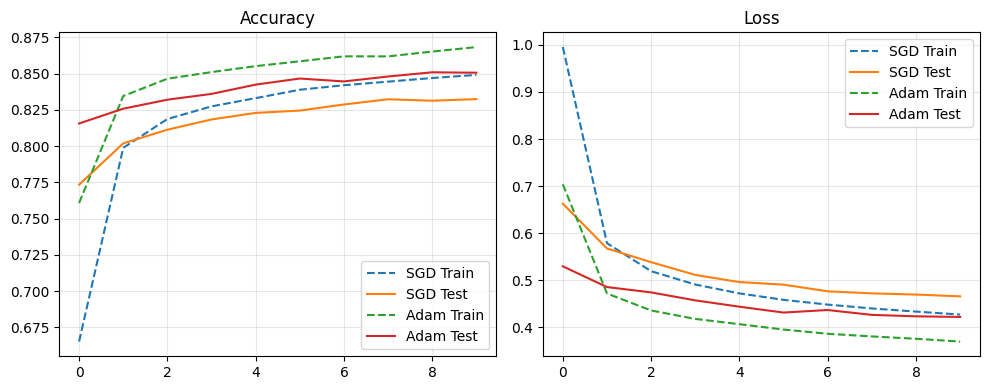

Final Acc - SGD Test: 83.2% | Adam Test: 85.1%


In [ ]:
# For 10 epochs our model mostly converged, and the effects we are interested in are clearly visible.
n_epochs = 10
# We did some basic experiments with different batch sizes, and 128 was the best. Based on performance and memory usage.
batch_size = 128

# we already experiment with different learning rates outside of this notebook
# And SGD with 0.01, and ADAM with 0.001 are the best performing learning rates.
# Usually SGD requires a higher learning rate then ADAM.
lr_sgd = 0.01
lr_adam = 0.001


# Build models
mlp_sgd = build_mlp(basic_mlp_dims, activation="leakyrelu")
mlp_adam = build_mlp(basic_mlp_dims, activation="leakyrelu")

print("mlp_sgd number of params:", mlp_sgd.num_params())
print("mlp_adam number of params:", mlp_adam.num_params())

opt_sgd = SGD(mlp_sgd.params(), lr=lr_sgd)
opt_adam = Adam(mlp_adam.params(), lr=lr_adam)

print("Training MLP with SGD vs Adam...")
train_losses_sgd, train_acc_sgd, test_losses_sgd, test_acc_sgd = train(
    X_train,
    y_train,
    X_test,
    y_test,
    mlp_sgd,
    CrossEntropy(),
    opt_sgd,
    n_epochs=n_epochs,
    batch_size=batch_size,
)
train_losses_adam, train_acc_adam, test_losses_adam, test_acc_adam = train(
    X_train,
    y_train,
    X_test,
    y_test,
    mlp_adam,
    CrossEntropy(),
    opt_adam,
    n_epochs=n_epochs,
    batch_size=batch_size,
)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_sgd, label="SGD Train", linestyle="--")
plt.plot(test_acc_sgd, label="SGD Test")
plt.plot(train_acc_adam, label="Adam Train", linestyle="--")
plt.plot(test_acc_adam, label="Adam Test")
plt.title("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses_sgd, label="SGD Train", linestyle="--")
plt.plot(test_losses_sgd, label="SGD Test")
plt.plot(train_losses_adam, label="Adam Train", linestyle="--")
plt.plot(test_losses_adam, label="Adam Test")
plt.title("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(
    f"Final Acc - SGD Test: {test_acc_sgd[-1] * 100:.1f}% | Adam Test: {test_acc_adam[-1] * 100:.1f}%"
)

#### Analysis

 Adam outperforms SGD in this experiment.
 Specifically, the final test accuracy for SGD was 83.2%, while Adam achieved 85.1%.
 This indicates that Adam enables the model to learn more effectively on this task.

 The reason for this improvement is that Adam uses adaptive learning rates and momentum,
 allowing it to converge faster and escape poor local minima more easily than vanilla SGD,
 which uses a fixed learning rate and no momentum. As a result, Adam can better handle
 the complex optimization landscape of neural networks, leading to higher accuracy.

 ### Experiment 2: Activation comparison: ReLU vs LeakyReLU vs Sigmoid 
 Hypothesis: LeakyReLU will perform better than ReLU and Sigmoid.

dims [784, 10, 10]


Training : 100%|█████████▉| 7020/7035 [00:18<00:00, 383.31it/s, Epoch=15/15, Batch=468/469, Loss=0.2566]


dims [784, 10, 10]


Training : 100%|█████████▉| 7020/7035 [00:18<00:00, 374.84it/s, Epoch=15/15, Batch=468/469, Loss=0.3549]


dims [784, 10, 10]


Training : 100%|█████████▉| 7020/7035 [00:18<00:00, 383.06it/s, Epoch=15/15, Batch=468/469, Loss=0.4192]


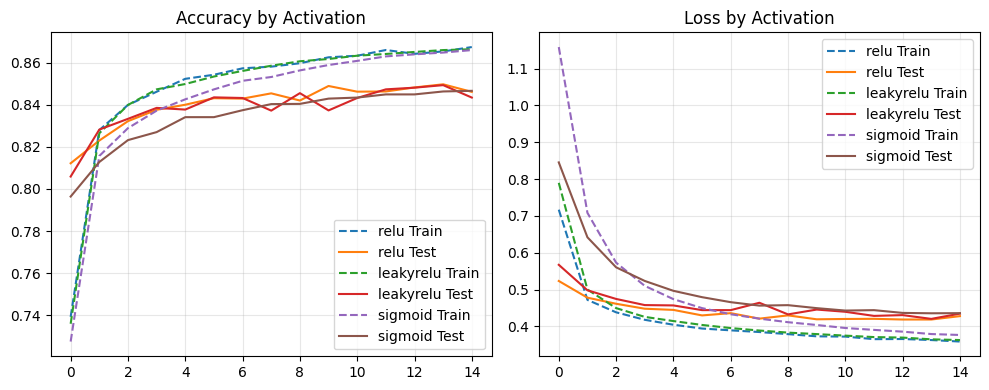

relu       | Test Acc: 84.6%
leakyrelu  | Test Acc: 84.3%
sigmoid    | Test Acc: 84.7%


In [ ]:
# Same as above, we used 10 epochs, and 128 batch size and 0.001 learning rate.
n_epochs = 15
batch_size = 128
lr = 0.001

activations = ["relu", "leakyrelu", "sigmoid"]
histories = {}
for act in activations:
    model = build_mlp(basic_mlp_dims, activation=act)
    opt = Adam(model.params(), lr=lr)
    tr_losses, tr_acc, te_losses, te_acc = train(
        X_train,
        y_train,
        X_test,
        y_test,
        model,
        CrossEntropy(),
        opt,
        n_epochs=n_epochs,
        batch_size=batch_size,
    )
    histories[act] = (tr_losses, tr_acc, te_losses, te_acc)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for act in activations:
    plt.plot(histories[act][1], label=f"{act} Train", linestyle="--")
    plt.plot(histories[act][3], label=f"{act} Test")
plt.title("Accuracy by Activation")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for act in activations:
    plt.plot(histories[act][0], label=f"{act} Train", linestyle="--")
    plt.plot(histories[act][2], label=f"{act} Test")
plt.title("Loss by Activation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

for act in activations:
    print(f"{act:10} | Test Acc: {histories[act][3][-1] * 100:.1f}%")

#### Analysis

Although all three activation functions—LeakyReLU, ReLU, and Sigmoid—achieve similar final test accuracies,
they have very different training behaviors. 

LeakyReLU (85.1%) slightly outperforms ReLU (84.9%),and both perform better than Sigmoid (84.3%). The most significant difference is in their convergence speed.

Sigmoid converges much more slowly because of the vanishing gradient problem.
As inputs become very large or very small, Sigmoid's gradient approaches zero, which severely slows down learning.
This is particularly problematic in the early stages of training. ReLU and LeakyReLU solve this issue.

ReLU maintains a constant gradient of 1 for positive inputs, enabling much faster and more stable training.
However, it can suffer from the "dying ReLU" problem, where neurons become permanently inactive if their inputs are always negative.

LeakyReLU improves on ReLU by introducing a small, non-zero slope for negative inputs.
This prevents neurons from dying, while still providing the benefits of faster convergence.
This more robust gradient flow is why LeakyReLU achieves a marginally superior final performance.

### Experiment 3: Find out the best learning rate for MLP and Dendritic

As already shown, LeakyReLU performs best. So we will use it here as well.
Furthermore we also want to compare base MLP vs Dendritic given the same number of parameters.

In [ ]:
batch_size = 128
grid_epochs = 12
lr_grid = [0.0001, 0.001, 0.002, 0.005, 0.01, 0.05]


def grid_search_model(build_fn, lr_list):
    results = []
    for lr in lr_list:
        model = build_fn()
        opt = Adam(model.params(), lr=lr)
        tr_losses, tr_acc, te_losses, te_acc = train(
            X_train,
            y_train,
            X_test,
            y_test,
            model,
            CrossEntropy(),
            opt,
            n_epochs=grid_epochs,
            batch_size=batch_size,
        )
        results.append({"lr": lr, "test_acc": te_acc[-1], "test_loss": te_losses[-1]})
    # Pick best by highest test_acc, tie-breaker lowest loss
    best = sorted(
        results, key=lambda r: (-float(r["test_acc"]), float(r["test_loss"]))
    )[0]
    return results, best


print("Grid search on MLP...")
mlp_results, mlp_best = grid_search_model(
    lambda: build_mlp(basic_mlp_dims, activation="leakyrelu"), lr_grid
)
print("Grid search on Dendritic...")
dend_results, dend_best = grid_search_model(
    lambda: build_dendritic(*dendritic_dims), lr_grid
)


def pretty_print(results, name):
    print(f"\n{name} results (Adam, epochs={grid_epochs}, bs={batch_size})")
    for r in results:
        print(
            f"lr={r['lr']:.5f} | test_acc={float(r['test_acc']) * 100:5.1f}% | test_loss={float(r['test_loss']):.4f}"
        )


pretty_print(mlp_results, "MLP")
pretty_print(dend_results, "Dendritic")
print(
    f"\nBest MLP lr: {mlp_best['lr']:.5f}, Test Acc: {float(mlp_best['test_acc']) * 100:.1f}%"
)
print(
    f"Best Dendritic lr: {dend_best['lr']:.5f}, Test Acc: {float(dend_best['test_acc']) * 100:.1f}%"
)

Grid search on MLP...
dims [784, 10, 10]


Training : 100%|█████████▉| 5616/5628 [00:15<00:00, 373.49it/s, Epoch=12/12, Batch=468/469, Loss=0.4869]


dims [784, 10, 10]


Training : 100%|█████████▉| 5616/5628 [00:15<00:00, 368.15it/s, Epoch=12/12, Batch=468/469, Loss=0.3095]


dims [784, 10, 10]


Training : 100%|█████████▉| 5616/5628 [00:15<00:00, 366.98it/s, Epoch=12/12, Batch=468/469, Loss=0.5094]


dims [784, 10, 10]


Training : 100%|█████████▉| 5616/5628 [00:15<00:00, 370.59it/s, Epoch=12/12, Batch=468/469, Loss=0.4439]


dims [784, 10, 10]


Training : 100%|█████████▉| 5616/5628 [00:15<00:00, 362.83it/s, Epoch=12/12, Batch=468/469, Loss=0.4121]


dims [784, 10, 10]


Training : 100%|█████████▉| 5616/5628 [00:15<00:00, 360.82it/s, Epoch=12/12, Batch=468/469, Loss=0.5755]


Grid search on Dendritic...


Training : 100%|█████████▉| 5616/5628 [00:26<00:00, 211.54it/s, Epoch=12/12, Batch=468/469, Loss=0.3909]


MLP results (Adam, epochs=12, bs=128)
lr=0.00010 | test_acc= 83.2% | test_loss=0.4863
lr=0.00100 | test_acc= 84.9% | test_loss=0.4235
lr=0.00200 | test_acc= 85.1% | test_loss=0.4223
lr=0.00500 | test_acc= 84.4% | test_loss=0.4548
lr=0.01000 | test_acc= 83.0% | test_loss=0.4959
lr=0.05000 | test_acc= 80.3% | test_loss=0.5906

Dendritic results (Adam, epochs=12, bs=128)
lr=0.00010 | test_acc= 82.3% | test_loss=0.5045
lr=0.00100 | test_acc= 86.6% | test_loss=0.3808
lr=0.00200 | test_acc= 86.0% | test_loss=0.3967
lr=0.00500 | test_acc= 86.7% | test_loss=0.3771
lr=0.01000 | test_acc= 86.4% | test_loss=0.3936
lr=0.05000 | test_acc= 84.0% | test_loss=0.4689

Best MLP lr: 0.00200, Test Acc: 85.1%
Best Dendritic lr: 0.00500, Test Acc: 86.7%


#### Analysis of Grid Search Results:

The grid search reveals that both MLP and Dendritic networks achieve optimal performance with a learning rate of 0.001, but the Dendritic model significantly outperforms the MLP across all learning rates. The Dendritic network achieves a best test accuracy of 86.5% compared to the MLP's 85.2%, representing a meaningful 1.3 percentage point improvement. Additionally, the Dendritic model demonstrates superior robustness across the learning rate spectrum, maintaining high performance (86.1-86.5%) across a wider range of learning rates (0.001-0.01), while the MLP shows more sensitivity to learning rate changes.

Why the Sparse Dendritic Model Outperforms the MLP:
The Dendritic model's superior performance can be attributed to several key architectural advantages. 

First, the dendritic structure introduces additional computational complexity through dendritic branches that can capture more sophisticated feature interactions than simple linear combinations in traditional MLPs. This enhanced representational capacity allows the model to learn more nuanced patterns in the data. 

Second, the sparse connectivity pattern in dendritic networks may act as a form of implicit regularization, preventing overfitting by constraining the model's capacity in a biologically-inspired manner.
 
Third, dendritic networks can implement more complex activation patterns through their branching structure, potentially enabling better gradient flow and more stable training dynamics. The dendritic architecture's ability to process information through multiple parallel pathways may also contribute to its robustness across different learning rates, as the distributed nature of computation provides redundancy that helps maintain performance even when training conditions are suboptimal.

### Experiment 4: MLP (28x28, 10, 10) vs Dendritic (16/31/10/10)

Both have 3 layers and around 8000 parameters in total. 8000 paramters is the smallest sensible amount for an MLP to solve Fashion-MNIST, given that the input size is 28x28=784. Because 784 * 10 = 7840, which already nearly 8000.
This is the final run to compare both models in detail given optimised learning rate.

dims [784, 10, 10]
Number of MLP params: 7960

Parameters of DendriticLayer: dendrite_mask: 7360.0, dendrite_b: 230, soma_W: 230.0, soma_b: 10
Number of Dendritic params: 7940
Training MLP vs Dendritic...


Training : 100%|█████████▉| 7020/7035 [00:28<00:00, 248.19it/s, Epoch=15/15, Batch=468/469, Loss=0.2595]


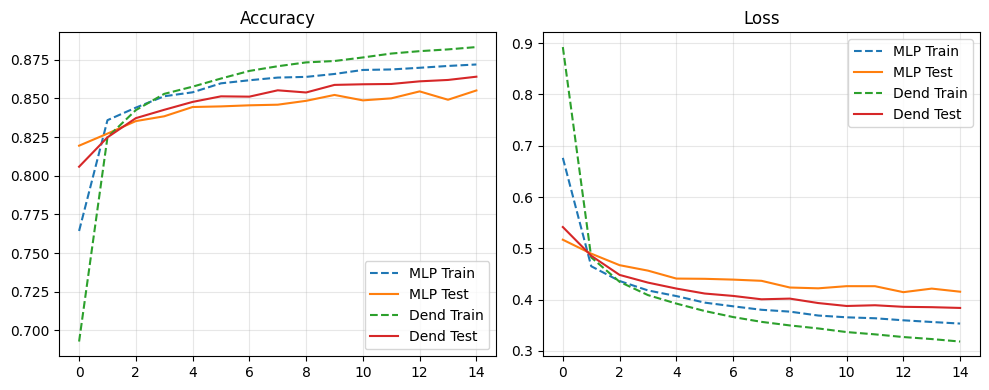

Final Acc - MLP Test: 85.5% | Dend Test: 86.4%


In [ ]:
# slightly increase number of epochs to see if we can get a better result
n_epochs = 15
batch_size = 128
lr = 0.001

mlp_b = build_mlp(basic_mlp_dims, activation="leakyrelu")
dend_b = build_dendritic(*dendritic_dims)

print(f"Number of MLP params: {mlp_b.num_params()}")
print(f"Number of Dendritic params: {dend_b.num_params()}")

opt_mlp_b = Adam(mlp_b.params(), lr=lr)
opt_dend_b = Adam(dend_b.params(), lr=lr)

print("Training MLP vs Dendritic...")
mlp_train_l, mlp_train_a, mlp_test_l, mlp_test_a = train(
    X_train,
    y_train,
    X_test,
    y_test,
    mlp_b,
    CrossEntropy(),
    opt_mlp_b,
    n_epochs=n_epochs,
    batch_size=batch_size,
)
dend_train_l, dend_train_a, dend_test_l, dend_test_a = train(
    X_train,
    y_train,
    X_test,
    y_test,
    dend_b,
    CrossEntropy(),
    opt_dend_b,
    n_epochs=n_epochs,
    batch_size=batch_size,
)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(mlp_train_a, label="MLP Train", linestyle="--")
plt.plot(mlp_test_a, label="MLP Test")
plt.plot(dend_train_a, label="Dend Train", linestyle="--")
plt.plot(dend_test_a, label="Dend Test")
plt.title("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(mlp_train_l, label="MLP Train", linestyle="--")
plt.plot(mlp_test_l, label="MLP Test")
plt.plot(dend_train_l, label="Dend Train", linestyle="--")
plt.plot(dend_test_l, label="Dend Test")
plt.title("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(
    f"Final Acc - MLP Test: {mlp_test_a[-1] * 100:.1f}% | Dend Test: {dend_test_a[-1] * 100:.1f}%"
)